In [1]:
# First mount Google Drive to access the data
from google.colab import drive
drive.mount('/content/drive')

import os
import random
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import exposure
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Configuration
DATA_PATH = '/content/drive/MyDrive/MLData/Data'
SAMPLE_SIZE_PER_CLASS = 10    # Small sample for quick testing
TEST_SIZE = 0.3               # 30% for testing
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Verify the folder exists
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data folder not found at {DATA_PATH}. Please check the path.")

Mounted at /content/drive


In [2]:
# # Image Preprocessing Technique Comparison
# Comparing five distinct scenarios:
# 1. Original (no processing)
# 2. CLAHE only
# 3. Histogram Equalization only
# 4. Gaussian Blur (Noise Reduction) only
# 5. Sharpening only

# Load sample images
def load_sample_images(data_path, sample_size):
    classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    image_paths = []
    labels = []

    for class_name in classes:
        class_path = os.path.join(data_path, class_name)
        all_images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        sampled_images = random.sample(all_images, min(sample_size, len(all_images)))

        for img_name in sampled_images:
            image_paths.append(os.path.join(class_path, img_name))
            labels.append(class_name)

    return image_paths, labels

# Load the images
try:
    image_paths, labels = load_sample_images(DATA_PATH, SAMPLE_SIZE_PER_CLASS)
    print(f"Loaded {len(image_paths)} images from {len(set(labels))} classes")
    print(f"Classes: {list(set(labels))}")
except Exception as e:
    print(f"Error loading images: {e}")

Loaded 30 images from 3 classes
Classes: ['parkinson', 'normal', 'alzheimer']


In [3]:
# Define preprocessing techniques
def original_image(img):
    """Scenario 1: No processing"""
    return img

def clahe_processing(img):
    """Scenario 2: CLAHE only"""
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    if len(img.shape) == 2 or img.shape[2] == 1:
        return clahe.apply(img)
    else:
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        l = clahe.apply(l)
        lab = cv2.merge((l, a, b))
        return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

def hist_equalization(img):
    """Scenario 3: Histogram Equalization only"""
    if len(img.shape) == 2 or img.shape[2] == 1:
        return cv2.equalizeHist(img)
    else:
        ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        ycrcb[:,:,0] = cv2.equalizeHist(ycrcb[:,:,0])
        return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)

def gaussian_blur(img):
    """Scenario 4: Gaussian Blur only"""
    return cv2.GaussianBlur(img, (5,5), 0)

def sharpening(img):
    """Scenario 5: Sharpening only"""
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

def combined_preprocessing(img):
    """CLAHE + Sharpening"""
    clahe_img = clahe_processing(img)
    sharpened_img = sharpening(clahe_img)
    return sharpened_img

def median_sharpening(img):
    """Median Filter + Sharpening"""
    median_img = cv2.medianBlur(img, ksize=3)
    sharpened_img = sharpening(median_img)
    return sharpened_img

In [4]:
# Process images and prepare datasets for classification
def create_classification_datasets(image_paths, labels):
    techniques = {
        'Original': original_image,
        'CLAHE': clahe_processing,
        'Hist Equalization': hist_equalization,
        'Gaussian Blur': gaussian_blur,
        'Sharpening': sharpening,
        'CLAHE + Sharpening': combined_preprocessing,
        'Median + Sharpening': median_sharpening
    }

    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(labels)

    datasets = {}

    for name, func in techniques.items():
        X = []
        processed_labels = []

        for path, label in tqdm(zip(image_paths, labels), total=len(image_paths), desc=f"Processing {name}"):
            img = cv2.imread(path)
            if img is None:
                continue

            try:
                processed = func(img)
                # Resize and flatten for classifier
                resized = cv2.resize(processed, (64, 64))  # Reduced size for faster processing
                if len(resized.shape) == 3:
                    flattened = resized.flatten()
                else:
                    flattened = np.stack((resized,)*3, axis=-1).flatten()  # Make sure all have same dimensions
                X.append(flattened)
                processed_labels.append(label)
            except Exception as e:
                print(f"Error processing {path} with {name}: {e}")
                continue

        # Only store if we successfully processed images
        if len(X) > 0:
            X = np.array(X)
            y_processed = le.transform(processed_labels)
            X_train, X_test, y_train, y_test = train_test_split(X, y_processed, test_size=TEST_SIZE, random_state=RANDOM_SEED)
            datasets[name] = (X_train, X_test, y_train, y_test)

    return datasets, le

print("Creating datasets for each preprocessing technique...")
datasets, label_encoder = create_classification_datasets(image_paths, labels)
print(f"Created datasets for {len(datasets)} techniques")

Creating datasets for each preprocessing technique...


Processing Median + Sharpening: 100%|██████████| 30/30 [00:00<00:00, 156.65it/s]


Created datasets for 7 techniques


In [5]:
# Train and evaluate classifiers
def evaluate_techniques(datasets, label_encoder):
    results = []
    models = {}

    for name, (X_train, X_test, y_train, y_test) in datasets.items():
        print(f"\nEvaluating {name}...")

        # Train classifier (using reduced parameters for speed)
        clf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=RANDOM_SEED)
        start_time = time.time()
        clf.fit(X_train, y_train)
        training_time = time.time() - start_time

        # Predictions
        y_pred = clf.predict(X_test)

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Store results
        results.append({
            'technique': name,
            'accuracy': accuracy,
            'training_time': training_time,
            'precision': class_report['weighted avg']['precision'],
            'recall': class_report['weighted avg']['recall'],
            'f1_score': class_report['weighted avg']['f1-score']
        })

        models[name] = clf

        # Print summary
        print(f"Accuracy: {accuracy:.3f}")
        print(f"Training time: {training_time:.2f}s")
        print("Classification Report:")
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    return pd.DataFrame(results), models

print("\nEvaluating all techniques...")
metrics_df, trained_models = evaluate_techniques(datasets, label_encoder)


Evaluating all techniques...

Evaluating Original...
Accuracy: 0.444
Training time: 0.10s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.33      0.33      0.33         3
      normal       0.33      0.25      0.29         4
   parkinson       0.67      1.00      0.80         2

    accuracy                           0.44         9
   macro avg       0.44      0.53      0.47         9
weighted avg       0.41      0.44      0.42         9


Evaluating CLAHE...
Accuracy: 0.444
Training time: 0.09s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.50      0.67      0.57         3
      normal       0.33      0.25      0.29         4
   parkinson       0.50      0.50      0.50         2

    accuracy                           0.44         9
   macro avg       0.44      0.47      0.45         9
weighted avg       0.43      0.44      0.43         9


Evaluating Hist Equalization...
Accuracy: 


Technique Comparison based on Classifier Performance:
             technique  accuracy  f1_score  training_time     score
4           Sharpening     0.667     0.606           0.09  0.941092
2    Hist Equalization     0.556     0.561           0.09  0.817396
6  Median + Sharpening     0.556     0.516           0.09  0.750901
5   CLAHE + Sharpening     0.667     0.606           0.11  0.700000
1                CLAHE     0.444     0.429           0.09  0.504107
0             Original     0.444     0.416           0.10  0.397087
3        Gaussian Blur     0.333     0.333           0.09  0.292917

Recommended preprocessing technique: Sharpening
Achieved accuracy: 0.667
Based on classifier accuracy, F1 score, and training time


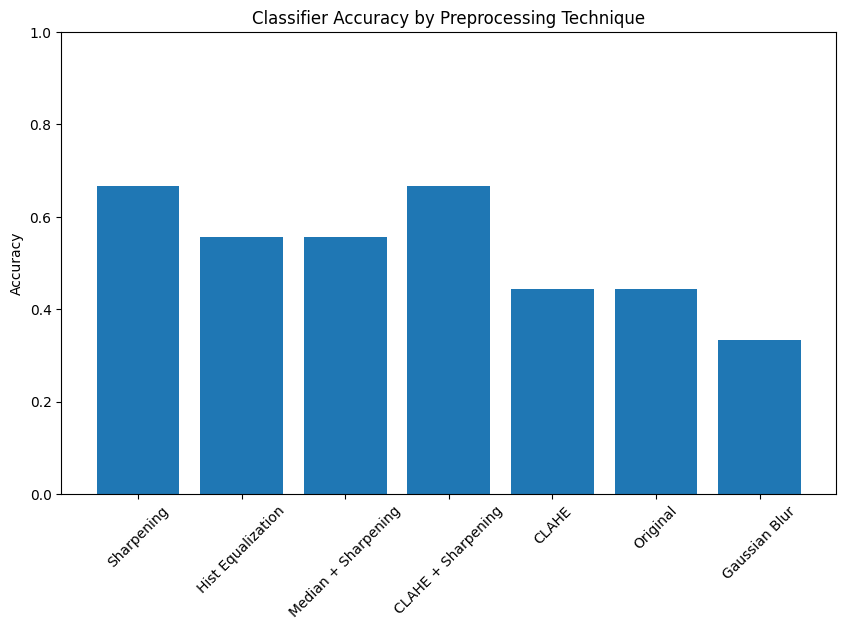

In [6]:
# Compare techniques
def compare_techniques(metrics_df):
    # Normalize metrics (higher is better for all except time)
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    for metric in metrics:
        min_val = metrics_df[metric].min()
        max_val = metrics_df[metric].max()
        metrics_df[f'norm_{metric}'] = (metrics_df[metric] - min_val) / (max_val - min_val)

    # Time should be lower (so we inverse it)
    min_time = metrics_df['training_time'].min()
    max_time = metrics_df['training_time'].max()
    metrics_df['norm_time'] = 1 - ((metrics_df['training_time'] - min_time) / (max_time - min_time))

    # Combined score (weighted average)
    weights = {
        'accuracy': 0.4,
        'f1_score': 0.3,
        'training_time': 0.3
    }

    metrics_df['score'] = (
        weights['accuracy'] * metrics_df['norm_accuracy'] +
        weights['f1_score'] * metrics_df['norm_f1_score'] +
        weights['training_time'] * metrics_df['norm_time']
    )

    # Formatting
    for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
        metrics_df[metric] = metrics_df[metric].round(3)
    metrics_df['training_time'] = metrics_df['training_time'].round(2)

    return metrics_df.sort_values('score', ascending=False)

print("\nTechnique Comparison based on Classifier Performance:")
comparison_df = compare_techniques(metrics_df)
print(comparison_df[['technique', 'accuracy', 'f1_score', 'training_time', 'score']])

# %%
# Recommendation
best_technique = comparison_df.iloc[0]['technique']
best_accuracy = comparison_df.iloc[0]['accuracy']
print(f"\nRecommended preprocessing technique: {best_technique}")
print(f"Achieved accuracy: {best_accuracy:.3f}")
print("Based on classifier accuracy, F1 score, and training time")

# %%
# Visualize results
plt.figure(figsize=(10, 6))
plt.bar(comparison_df['technique'], comparison_df['accuracy'])
plt.title('Classifier Accuracy by Preprocessing Technique')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.show()

# %%
# Save results
results = {
    'metrics': metrics_df,
    'comparison': comparison_df,
    'label_encoder': label_encoder
}

import pickle
with open('classification_results.pkl', 'wb') as f:
    pickle.dump(results, f)

comparison_df.to_csv('technique_comparison_classifier.csv', index=False)